In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

Extent       Date
0    1179855.894 1979-01-01
1     879585.254 1979-02-01
2     791619.096 1979-03-01
3    1254912.071 1979-04-01
4    1620142.247 1979-05-01
..           ...        ...
533  1556568.455 2023-06-01
534  1917507.979 2023-07-01
535  2601630.327 2023-08-01
536  2534223.780 2023-09-01
537  2373004.525 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [56]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [57]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 211ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 2/50
53/53 [==============================] - 10s 184ms/step - loss: 0.0956 - root_mean_squared_error: 0.3093 - val_loss: 0.0844 - val_root_mean_squared_error: 0.2905
Epoch 3/50
53/53 [==============================] - 10s 185ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2739
Epoch 4/50
53/53 [==============================] - 10s 201ms/step - loss: 0.0488 - root_mean_squared_error: 0.2210 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630
Epoch 5/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0455 - root_mean_squared_error: 0.2134 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2497
Epoch 6/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0398 - root_mean_squared_error: 0.1994 - val_loss: 0.0551 

Epoch 29/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 30/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265
Epoch 31/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 32/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0112 - root_mean_squared_error: 0.1059 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 33/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 34/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0171 - va

In [58]:
time = (etime - stime)/60
print(f'{time} minutes')

5.5772278785705565 minutes


In [59]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

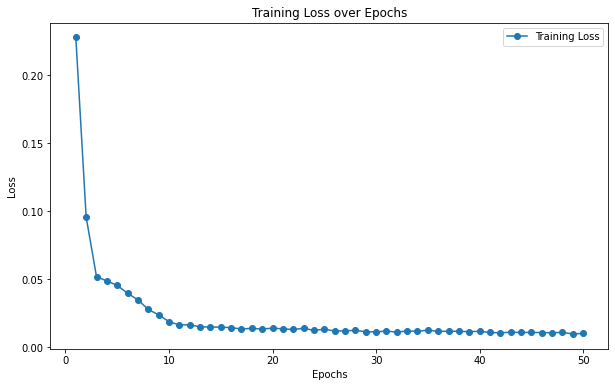

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

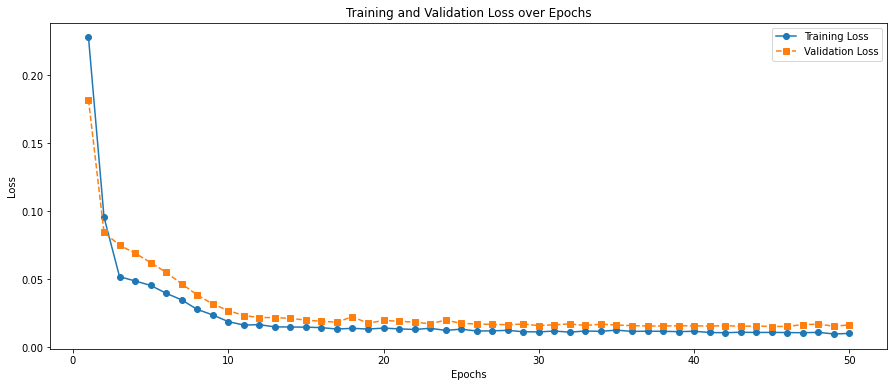

In [61]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 18ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09611450135642012
MAE : 0.08004449369513253


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        1.370548e+06    1234157.908
1        1.768189e+06    1575894.445
2        2.062439e+06    1714381.703
3        2.244893e+06    2067343.547
4        2.198686e+06    1856673.675
5        2.024252e+06    1914289.680
6        1.830461e+06    1802244.842
7        1.418037e+06    1202791.069
8        7.417897e+05     752834.272
9        5.379366e+05     451914.219
10       6.187219e+05     439855.813
11       8.910205e+05     807857.307
12       1.230005e+06    1184280.145
13       1.522825e+06    1468308.405
14       1.734383e+06    1540851.607
15       1.906564e+06    1989099.836
16       1.994187e+06    2096990.761
17       2.059341e+06    2080961.032
18       1.891308e+06    1695704.661
19       1.261606e+06    1533888.370
20       7.092767e+05    1038332.675
21       5.034509e+05     602954.621
22       5.664202e+05     895484.288
23       8.305259e+05    1070622.700
24       1.117201e+06    1532457.922
25       1.380616e+06    1703762.123
26       1.620060e+06    1855079.122
27       1.887301e+06    2291960.639
28       1.965465e+06    2114120.417
29       1.896501e+06    1995818.759
30       1.725178e+06    1653379.997
31       1.452992e+06    1070814.995
32       8.395842e+05     689443.815
33       5.825769e+05     401148.663
34       8.156619e+05     346558.057
35       1.077922e+06     599477.678
36       1.386862e+06     765764.905
37       1.667282e+06    1304133.179
38       1.914658e+06    1598436.099
39       2.111540e+06    1763844.414
40       2.146955e+06    1979139.524
41       2.107932e+06    1937348.663
42       1.867843e+06    1833093.342
43       1.208800e+06    1089676.114
44       7.260078e+05     453484.731
45       5.215755e+05     251559.554
46       5.221461e+05     351294.657
47       6.894281e+05     702389.714
48       9.791931e+05    1185169.054
49       1.355804e+06    1556568.455
50       1.661709e+06    1917507.979
51       1.919647e+06    2601630.327
52       2.112031e+06    2534223.780
53       2.164718e+06    2373004.525

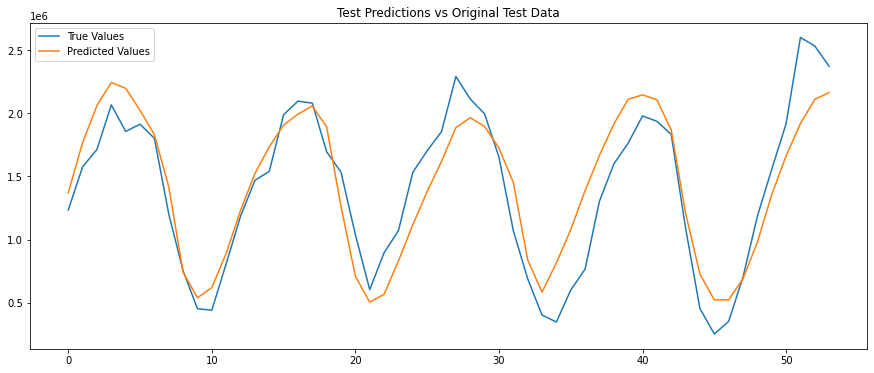

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

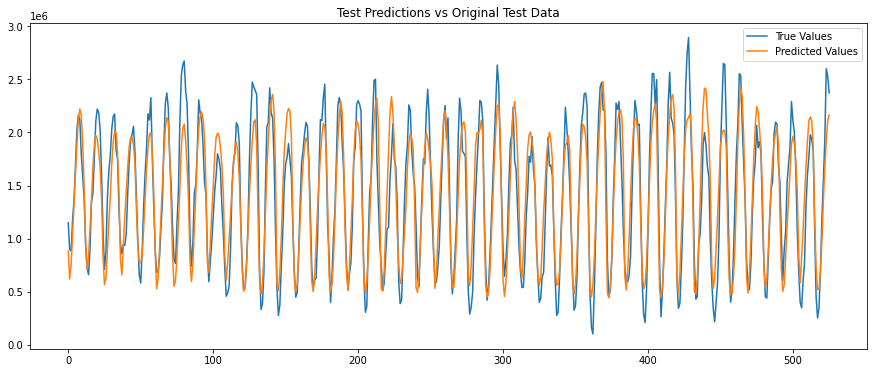

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()